In [1]:
# %%
import gym
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from src.utils.util import ShellColor as sc

print(f"{sc.COLOR_PURPLE}Gym version:{sc.ENDC} {gym.__version__}")
print(f"{sc.COLOR_PURPLE}Pytorch version:{sc.ENDC} {torch.__version__}")

from src.agents.dqn_agent import DQNAgent
from src.utils import util as rl_util
from src.envs.atari import make_env

Gym version: 0.18.0
Pytorch version: 1.12.0+cu113


In [2]:
env_name = "PongNoFrameskip-v4"
env = make_env(env_name)
rl_util.print_env_info(env=env)

============ Env Info ===========
Env id: PongNoFrameskip-v4
Observation space size: (4, 84, 84)
Action space size: 6
Action list: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [3]:
config = rl_util.create_config()
config["batch_size"] = 64
config["buffer_size"] = 20000
config["gamma"] = 0.99
config["target_update_frequency"] = 1000
config["lr"] = 1e-4
config["replay_start_size"] = 20000
config["mean_reward_bound"] = 10

In [4]:
wandb.init(project="DQN", config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wlseowhd12 (cau-railab). Use `wandb login --relogin` to force relogin
/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/home/djjin/anaconda3/envs/test/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [5]:
save_dir = "result/DQN/atari/"
rl_util.create_directory(save_dir)
save_model_name = save_dir + env_name + "_mean_score.pt"

In [6]:
agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
    config=config,
)
print(agent.config)
print(type(agent.memory))

Model Initializing... An input shape is (4, 84, 84)
Model Initializing... An input shape is (4, 84, 84)
========== Config Info ==========
n_episodes: 10000
batch_size: 64
gamma: 0.99
lr: 0.0001
epsilon_start: 1
epsilon_end: 0.01
seed: 0
target_update_frequency: 1000
buffer_type: uniform
buffer_size: 20000
device: cuda:0
replay_start_size: 20000
mean_reward_bound: 10
<class 'src.commons.memory.replay_memory.ReplayMemory'>


In [7]:
total_rewards = []
losses = []
total_reward = 0
frame_idx = 0
avg_loss = 0
best_mean_reward = -10000
state = env.reset()
training_start = True
done_reward = None
cnt = 0
print(agent.policy_network)

CNNModel(
  (features): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [8]:

while True:
    frame_idx += 1
    cnt += 1
    done_reward = None
    
    eps = max(agent.config.epsilon_end, agent.config.epsilon_start - frame_idx / 100000)
    agent.decay_epsilon(frame_idx)
    action = agent.select_action(state, eps)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    agent.store_transition(state, action, reward, next_state, done)
    state = next_state

    if done:
        done_reward = total_reward
        state = env.reset()
        total_reward = 0
        avg_loss /= cnt
        cnt = 0
    
    if done_reward is not None:
        total_rewards.append(done_reward)
        mean_reward = np.mean(total_rewards[-100:])
        losses.append(avg_loss)
        print(
            f"{frame_idx}: episode: {len(total_rewards)} | mean reward: {mean_reward:.3f} | loss: {avg_loss:.4f} | epsilon: {eps:.4f}"
        )
        wandb.log({
            "episode": len(total_rewards),
            "mean reward": mean_reward,
            "loss": avg_loss,
            "epsilon": eps
        })
        if best_mean_reward < mean_reward:
            torch.save(agent.policy_network.state_dict(), save_model_name)
            print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_reward:.3f}, model saved")
            best_mean_reward = mean_reward
            if mean_reward > agent.config.mean_reward_bound:
                print(f"Solved in {frame_idx} frames!")
                break
            else:
                if len(total_rewards) > 1000:
                    break

    if len(agent.memory.replay_buffer) < agent.config.replay_start_size:
        continue

    if training_start:
        print("Start Model Train..")
        training_start = False

    if frame_idx % agent.config.target_update_frequency == 0:
        # agent.soft_update_target_network()
        agent.update_target_network()
    loss = agent.update()
    avg_loss += loss
    
env.close()

1002: episode: 1 | mean reward: -19.000 | loss: 0.0000 | epsilon: 0.9900
Best mean reward updated -10000.000 -> -19.000, model saved
1979: episode: 2 | mean reward: -19.500 | loss: 0.0000 | epsilon: 0.9802
2879: episode: 3 | mean reward: -19.667 | loss: 0.0000 | epsilon: 0.9712
3689: episode: 4 | mean reward: -20.000 | loss: 0.0000 | epsilon: 0.9631
4793: episode: 5 | mean reward: -19.800 | loss: 0.0000 | epsilon: 0.9521
5694: episode: 6 | mean reward: -20.000 | loss: 0.0000 | epsilon: 0.9431
6732: episode: 7 | mean reward: -19.857 | loss: 0.0000 | epsilon: 0.9327
7522: episode: 8 | mean reward: -20.000 | loss: 0.0000 | epsilon: 0.9248
8799: episode: 9 | mean reward: -19.778 | loss: 0.0000 | epsilon: 0.9120
9997: episode: 10 | mean reward: -19.800 | loss: 0.0000 | epsilon: 0.9000
11049: episode: 11 | mean reward: -19.818 | loss: 0.0000 | epsilon: 0.8895
11978: episode: 12 | mean reward: -19.833 | loss: 0.0000 | epsilon: 0.8802
12888: episode: 13 | mean reward: -19.923 | loss: 0.0000 | 

KeyboardInterrupt: 

Save result/DQN/atari/reward_2023_02_11_06_26_29.png


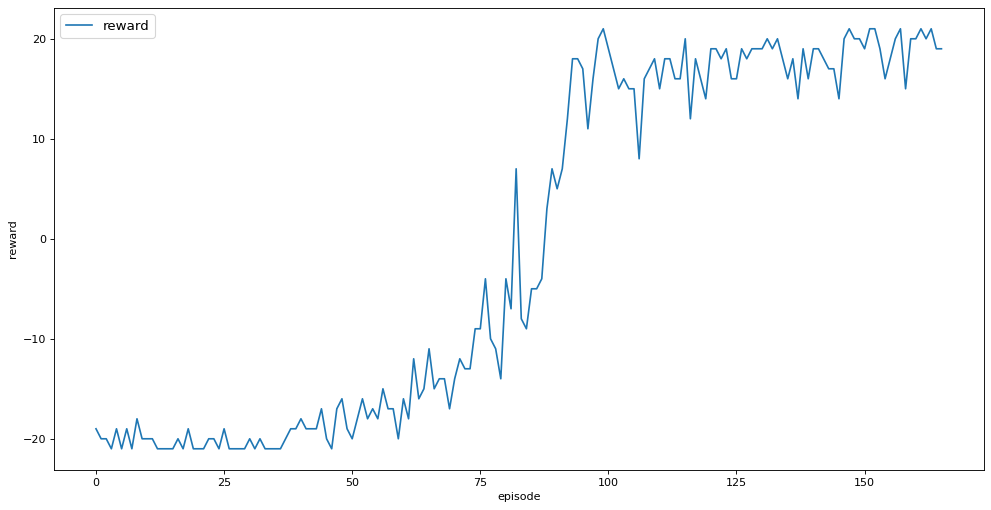

Save result/DQN/atari/loss_2023_02_11_06_26_29.png


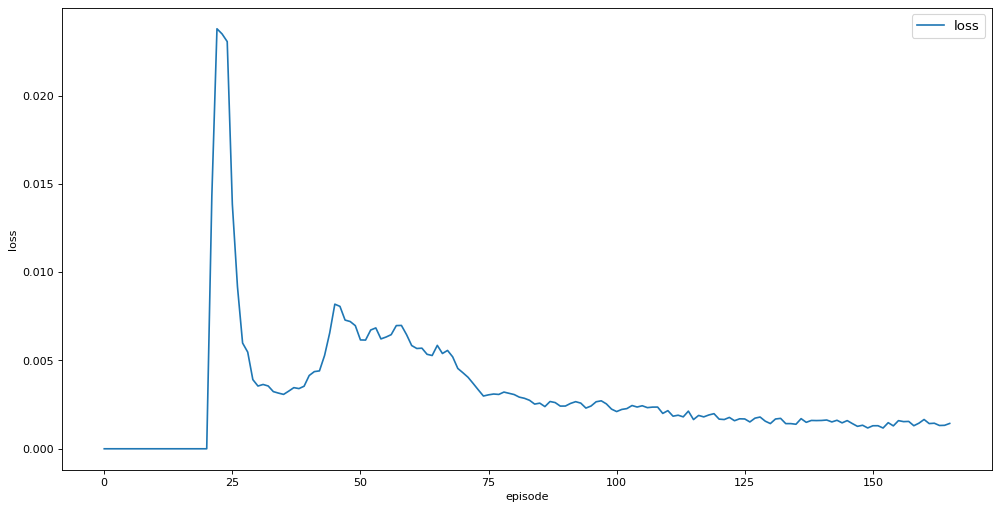

In [9]:
fig, ax = rl_util.init_2d_figure("Reward")
rl_util.plot_graph(
    ax,
    total_rewards,
    title="reward",
    ylabel="reward",
    save_dir_name=save_dir,
    is_save=True,
)
rl_util.show_figure()
fig, ax = rl_util.init_2d_figure("Loss")
rl_util.plot_graph(
    ax, losses, title="loss", ylabel="loss", save_dir_name=save_dir, is_save=True
)
rl_util.show_figure()

In [13]:
env = make_env(env_name)

test_agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
)
test_agent.policy_network.load_state_dict(torch.load(save_model_name))
total_reward = 0

total_reward = 0
state = env.reset()
while True:
    env.render()
    action = test_agent.select_action(state, 0.)
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break
env.close()

Model Initializing... An input shape is (4, 84, 84)
Model Initializing... An input shape is (4, 84, 84)
